In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# from paper_plots import box_violin, add_table_line, plot_experiment

import scipy.stats
import scikit_posthocs as sp
import numpy as np

In [2]:
main_font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

tick_font = {'fontname':'Arial', 'weight':'normal', 'size':8}

matplotlib.rc('font', **main_font)

In [3]:
def box_violin(data, position, color, ax):

    if not isinstance(position, list):
        position = [position]
    #plot violin
    parts = ax.violinplot(data, positions=position, vert=False,
                showmeans=False, showmedians=False,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.4)

    # plot boxplot
    ax.boxplot(data, positions=position, vert=False,
               showmeans=False, meanline=False, patch_artist=True,
               boxprops=dict(facecolor=color, color='k', linewidth=0.5),
               medianprops=dict(color='k' ),
               whiskerprops=dict(linewidth=0.5),
               flierprops =dict(markersize=1, marker='o'),
               # meanprops=dict(color='k',linestyle = ':')
               )

def add_table_line(y, text_info, values,
        include_info,
        include_stats):

    d = values.describe()
    d['IQR'] = d['75%']-d['25%']

    x_list_1 = [-0.2 * (i+1)  for i in range(len(include_stats ))]
#     x_list_2 = [-0.15 * (i) + min(x_list_1)-0.15 for i in range(len(include_info))]
    if include_info:
        x_list_2 = [ i+min(x_list_1) for i in [-0.3, -0.47, -.75] ] 
    else:
        x_list_2 = []
    x_list =  x_list_2 + x_list_1
    text = include_info[::-1]+include_stats[::-1]

    if y==0:
        for x, t in zip(x_list, text):
            t = t.replace('Normalisation', 'Norm')\
                 .replace('Learning_rate', 'LR')\
                 .replace('50%', 'M')\
                 .replace('Loss', 'LF')

            plt.text(x, y-0.5, t, fontweight='bold')

    for x,s  in zip(x_list_1[::-1], include_stats):
        plt.text(x, y,'{:.2f}'.format(d[s]), va='center')

    for x,s  in zip(x_list_2[::-1], include_info):

        t = text_info[s]

        if isinstance(t, float):
            t = '{:.0e}'.format(t)
        else:
            t = t.replace('Z-Score', 'ZS').replace(' ','').replace('ModifiedDiceLoss', 'mDL')\
                                                            .replace('BinaryFbetaLoss', 'DL')
        plt.text(x, y, t, va='center')

def plot_experiment(src, id_0, result, position, row_info, n_fold=5, color='#ff8c00',
    include_info = ['Dataset', 'Channels', 'Normalisation','Learning_rate', 'Loss'],
    include_stats = ['50%', 'IQR']):
#     marker_folds = ['v', '<', '^', '>', 'D']
    marker_folds = ['x']*5

    prefix, idx = id_0.split('_')
    idx = int(idx)

    f_comb = prefix + '_' + '_'.join([str(i) for i in range(idx, idx+n_fold)]) +'_'+result+'.csv'

    main_data = pd.read_csv(os.path.join(src,f_comb))['f1_score']

    box_violin(main_data.to_list(),position,color, plt.gca())


    for i, p in zip(range(n_fold), [-0.2,-0.1, 0, .1, .2]):
        fold_data= pd.read_csv(os.path.join(src,prefix+'_'+str(i+idx),
            result+'.csv'))['f1_score']
        m = fold_data.describe()['50%']
        plt.plot(m, position+p, marker_folds[i]+'k', zorder=5000, 
                 markersize=1.5, 
                 markeredgecolor= 'k', #636363', 
                 markeredgewidth=0.5,
#                  markerfacecolor='k'
                ) 

    add_table_line(position, row_info, main_data, include_info, include_stats)


In [4]:
def friedmann_test(src, id_0_list):
    n_fold=5
    
    data = []
    for id_0 in id_0_list:
        prefix, idx = id_0.split('_')
        idx = int(idx)
        result = 'patient'

        f_comb = prefix + '_' + '_'.join([str(i) for i in range(idx, idx+n_fold)]) +'_'+result+'.csv'
    
        main_data = pd.read_csv(os.path.join(src,f_comb))['f1_score']

        data.append(main_data.to_list())
    

    # friedman test
    result = scipy.stats.friedmanchisquare(*data)
    
    print(result)
    print('pvalue < 0.0001', result.pvalue < 0.0001)
    
    # Nemenyi 
    d = np.array(data)
    result_2 = sp.posthoc_nemenyi_friedman(d.T)
#     print(result_2)
    r_text = result_2.copy()
    for r in result_2.index:
        for c in result_2.columns:
            v = result_2[c][r] 
            if   v >  0.5   : t = 'ns'
            elif v <= 0.0001: t = '****'
            elif v <= 0.001 : t = '***'
            elif v <= 0.01 :  t = '**'
            elif v <= 0.05 :  t = '*'
            
            r_text[c][r] = t
    
    r_text.columns = id_0_list
    r_text.index = id_0_list
    print(r_text)
    
    return(r_text)
    
#     sig_level = [0.05, .01, .001, 0.001, 0.0001]
#     for s in sig_level[::-1]:
#         print('\n\n p <', s)
#         i_1, i_2 = (np.where(result_2 < s))
        
#         if len(i_1)>0:
#             for k in i_1:
#                 bla.append

    # find highest rank sum 
    ranks = scipy.stats.rankdata(data).reshape(len(data),len(data[0]))
    result_ranks = np.array([p.sum() for p in ranks])
    highest_rank = np.argmax(result_ranks)
    print(result_ranks, highest_rank, id_0_list.to_list()[highest_rank])


---
Create Fig 1

- results of the parameter optimization on C1
- separate subplots for T2w and T2w+DW
- Table with Median (M) and Interquartile range (IQR)
- Markers for the results of the individual folds

T2w
FriedmanchisquareResult(statistic=30.829710144927503, pvalue=6.683448314319372e-05)
pvalue < 0.0001 True


<ipython-input-4-05c05659819c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_text[c][r] = t
C:\Users\franzihk\AppData\Local\Continuum\anaconda3\envs\pyingvild\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ID        bigart_75 bigart_55 bigart_20 bigart_0 bigart_80 bigart_60  \
ID                                                                     
bigart_75        ns        ns        ns       ns        ns        ns   
bigart_55        ns        ns        ns       ns        ns        ns   
bigart_20        ns        ns        ns        *        ns        ns   
bigart_0         ns        ns         *       ns         *        ns   
bigart_80        ns        ns        ns        *        ns        ns   
bigart_60        ns        ns        ns       ns        ns        ns   
bigart_25        ns        **        ns      ***        ns        ns   
bigart_5         ns        ns        ns        *        ns        ns   

ID        bigart_25 bigart_5  
ID                            
bigart_75        ns       ns  
bigart_55        **       **  
bigart_20        ns       ns  
bigart_0        ***        *  
bigart_80        ns       ns  
bigart_60        ns       ns  
bigart_25        ns       ns  


<ipython-input-4-05c05659819c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_text[c][r] = t
C:\Users\franzihk\AppData\Local\Continuum\anaconda3\envs\pyingvild\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


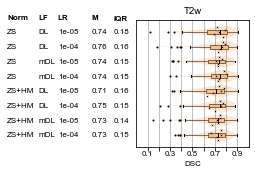

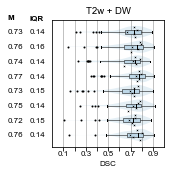

In [8]:
src = r'D:\BiGART_results'
df = pd.read_csv('experiments.csv')
df.drop_duplicates(subset=df.columns.difference(
                                ['ID','validation_fold', 'Status']),
                                keep='first', inplace=True)
df = df.loc[df['Dataset'].isin(['Oxytarget'])]

df.sort_values(['Normalisation', 'Loss', 'Learning_rate', ], inplace=True)

sf = 1
cm = 1/2.54  # centimeters in inches


include_info = ['Normalisation', 'Loss', 'Learning_rate']

for (input_set, c) in [('T2w', '#fdbe85'), 
                  ('T2w + DW', '#bdd7e7')]:
    fig, ax = plt.subplots(1,1, figsize= (9*cm *sf , 6*cm))
    
    df_input_set = df.loc[df['Channels'].isin([input_set])]
    for idx, (_, e) in enumerate(df_input_set.iterrows()):
        plot_experiment(src, e['ID'], 'patient', idx*0.6, e,  color=c, include_info=include_info)
    
    ax.set_ylim(ax.get_ylim()[::-1])

    plt.subplots_adjust(left=0.55, bottom=0.15, right=0.99, top=0.90, wspace=None, hspace=None)

    ax.set_title(input_set)
    ax.set(xlim=[0,1], 
           xlabel='DSC',
           xticks=[0.1*i for i in range(1,10)],
           xticklabels=[0.1, '', 0.3, '', 0.5 , '', 0.7, '', 0.9],
           yticks=[]
          )
#     ax.minorticks_on()
    ax.grid(which='major', color='#666666', linestyle='-', axis='x', alpha=0.5)

    ax.tick_params(axis='x', which='major', pad=0)
    
    plt.savefig('..\Paper_2\gfx\Fig_1_' + input_set.replace(' + ', '-') +'.pdf',
               dpi=300)
    
    include_info = []
    
    
    # friedman test
    print(input_set)
    r = friedmann_test(src, df_input_set['ID'])
    r.to_csv('neyman_'+ input_set +'.csv')
    print('\n\n')